<a href="https://colab.research.google.com/github/vkarakcheev/DS/blob/main/logit_vs_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logit vs Forest

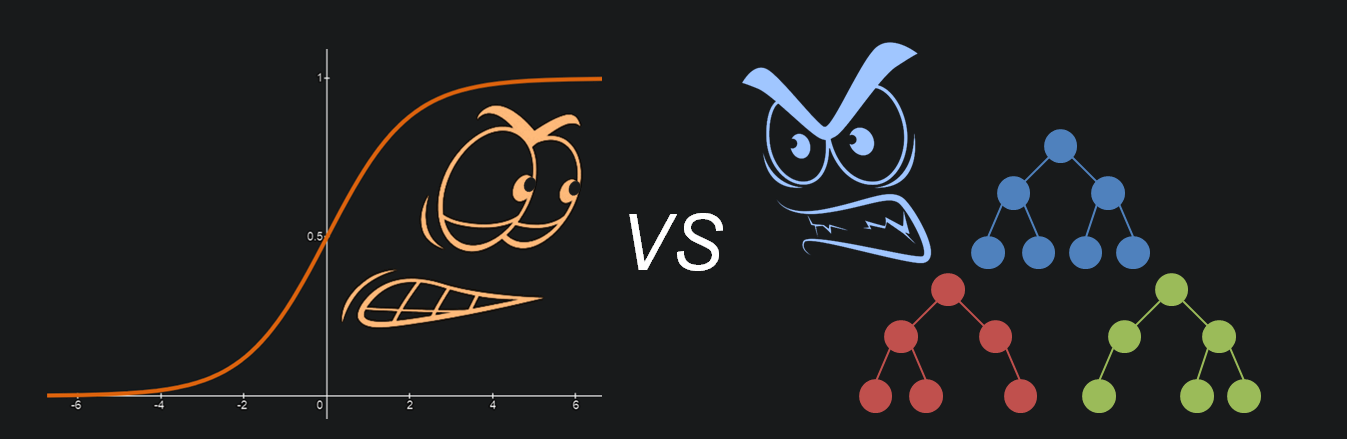

---

Цель проекта – подтвердить или опровергнуть следующее утверждение-гипотезу [отсюда](https://youtu.be/Us_TKT8ZL2E?t=5299).
>*В задаче бинарной классификации **любые** метрики качества модели логистической регрессии будут **гораздо** лучше метрик модели случайного леса, если **подавляющее большинство** признаков в данных являются незначащими (шумом).* 

# Prepare to Fight

Подключим необходимые модули, выставим полезные умолчания.

In [2]:
!pip install scikit-optimize catboost

     |████████████████████████████████| 100 kB 4.1 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from catboost import CatBoostClassifier
from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             RocCurveDisplay, PrecisionRecallDisplay)

plt.style.use('dark_background');            # Dark theme for plots
plt.rc('grid', color=(.3, .3, .3));          # Pale grid lines
plt.rc('axes', grid=True, axisbelow=True);   # Grid lines behind the plot
pd.set_option('display.max_columns', None);  # Display all dataframe columns

# Disable warnings
pd.options.mode.chained_assignment = None;   
warnings.simplefilter('ignore', pd.errors.PerformanceWarning);
warnings.simplefilter('ignore', UserWarning);

Определим ключевые константы.

In [4]:
# General constants
RS = 22221117  # Random state
N_ITER = 20    # Iterations in Bayesian search
CV = 5         # Cross validation folds

# Random forest constants
N_ESTIMATORS_SPACE = list(range(1, 100+1))
MAX_DEPTH_SPACE = list(range(1, 30+1))
FOREST_SPACE = {
    'n_estimators': N_ESTIMATORS_SPACE,
    'max_depth': MAX_DEPTH_SPACE,
}

# Logit constants
C_SPACE = np.logspace(-2, 2, 9)
L1_RATIO_SPACE = [.25, .5, .75]
LOGIT_SPACE = [
    {'solver': ['newton-cg', 'lbfgs', 'sag'],
     'penalty': ['l2', 'none'], 
     'C': C_SPACE},
    {'solver': ['liblinear'],
     'penalty': ['l1', 'l2'], 
     'C': C_SPACE},
    {'solver': ['saga'],
     'penalty': ['l1', 'l2', 'none'], 
     'C': C_SPACE},
    {'solver': ['saga'],
     'penalty': ['elasticnet'], 
     'C': C_SPACE,
     'l1_ratio': L1_RATIO_SPACE},
]

Датасеты для анализа будем генерировать функцией [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) библиотеки `scikit-learn`, которая делает следующее.
1. Генерирует 2<sup>`n_informative`</sup> кластеров точек (наборов признаков), нормально распределенных вокруг вершин `n_informative`-мерного гиперкуба с длиной ребра 2 × `class_sep`.
2. Относит по `n_clusters_per_class` кластеров к каждому из `n_classes` классов.
3. Оставшиеся кластеры (если есть) игнорирует.
4. Добавляет:
    - `n_redundant` избыточных признаков, являющихся случайной линейной комбинацией `n_informative` значащих признаков,
    - `n_repeated` признаков-дубликатов значащих и избыточных признаков (с возвращениями)
    - и (`n_features` − `n_informative` − `n_redundant` − `n_repeated`) незначащих признаков (случайный шум).

Если передать функции аргумент `shuffle=False`, то `n_features` столбцов признаков будут следовать в следующем порядке:
- `n_informative` значащих,
- `n_redundant` избыточных,
-  `n_repeated` дубликатов
- и (`n_features` − `n_informative` − `n_redundant` − `n_repeated`) незначащих признаков.

Для простоты, скорости и наглядности будем генерировать датасеты с *тремя* значащими признаками (чтобы визуализировать их в 3D-диаграммах) и разным количеством незначащих, меняя таким образом долю значащих признаков.

Для начала напишем функцию `plot_blobs`, которая генерирует и визуализирует датасет с заданными параметрами. В ней ребро куба намеренно сделаем увеличенным (`class_sep=5`), чтобы лучше видеть относительное расположение кластеров.

In [5]:
def plot_blobs(n_samples=1000, n_features=3, n_informative=3, 
                n_clusters_per_class=3, class_sep=5, n_redundant=0, 
                n_repeated=0, random_state=RS, title=None):
    '''Generates dataset and plots its 3D visualization'''
    
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_repeated=n_repeated,
        n_clusters_per_class=n_clusters_per_class,
        class_sep=class_sep,
        random_state=random_state,
        shuffle=False,  # All informative features are in first columns
    )

    X, y = pd.DataFrame(X), pd.Series(y)
    c0, c1 = y == 0, y == 1

    fig = plt.figure(figsize=(10, 8));
    fig.suptitle(title, y=.9, fontsize='xx-large');
    ax = fig.add_subplot(projection='3d');

    ax.scatter(X[c0][0], X[c0][1], X[c0][2], label='Class 0', c='b', 
               edgecolors='k');
    ax.scatter(X[c1][0], X[c1][1], X[c1][2], label='Class 1', c='r', 
               edgecolors='k');

    ax.set(xlabel='Feature 1', ylabel='Feature 2', zlabel='Feature 3')
    ax.legend();

Теперь напишем функцию `plot_curves`, которая для обученной модели и выборки рисует кривые ROC и Precision-Recall, заодно считая площади под ними: AUC и AP.

In [18]:
def plot_curves(estimator, X, y, title=''):
    '''Plots ROC and Precision-Recall curves
    for a given estimator, X and y.
    '''
    
    if hasattr(estimator, 'best_estimator_'):
        estimator = estimator.best_estimator_
    
    # Prepare axes
    fig, ax = plt.subplots(1, 2, figsize=(10, 3));
    fig.suptitle(title + estimator.__class__.__name__);
    ax[0].set(xlim=(-.05, 1.05), ylim=(-.05, 1.05));
    ax[1].set(xlim=(-.05, 1.05), ylim=(-.05, 1.05));
    ax[0].plot([0, 1], [0, 1], linestyle='--', color=(.3, .3, .3));
    ax[1].plot([0, 1], [.5, .5], linestyle='--', color=(.3, .3, .3));

    # Plot curves
    RocCurveDisplay.from_estimator(estimator, X, y, ax=ax[0], name='');
    PrecisionRecallDisplay.from_estimator(estimator, X, y, ax=ax[1], name='');

    # Mark the point of threshold = 0.5
    tn, fp, fn, tp = confusion_matrix(y, estimator.predict(X)).ravel()
    ax[0].plot(fp/(tn+fp), tp/(tp+fn), 'ro');
    ax[1].plot(tp/(tp+fn), tp/(tp+fp), 'ro');
    
    plt.show();

Наконец, напишем основную функцию `fight`, которая:
- генерирует датасет по заданным параметрам,
- разбивает его на обучающую и тестовую выборки,
- подбирает гиперпараметры моделей случайного леса и логистической регрессии на обучающей выборке с помощью байесовкого поиска со встроенной кросс-валидацией,
- определяет модель-победителя по метрике AUC ROC на тестовой выборке,
- рисует кривые ROC и Precision-Recall моделей на тестовой выборке.

Функция также опционально (если аргумент `cat=True`) обучает и тестирует модель градиентного бустинга CatBoost для использования в качестве бенчмарка.

In [20]:
def fight(n_samples=1000, n_features=3, n_informative=3, 
          n_clusters_per_class=3, class_sep=1, n_redundant=0, n_repeated=0,
          random_state=RS, cat=False, title=''):
    '''Generates dataset, selects hyperparameters for Random Forest
    and Logistic Regression models and compares their metrics.
    Optionally adds CatBoost model results as a benchmark.
    '''
    # Generate and split dataset
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_repeated=n_repeated,
        n_clusters_per_class=n_clusters_per_class,
        class_sep=class_sep,
        random_state=random_state
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.25, stratify=y, random_state=RS)
   
    # Select hyperparameters
    logit = BayesSearchCV(
        LogisticRegression(max_iter=10000, random_state=RS), 
        LOGIT_SPACE, 
        n_iter=N_ITER // len(LOGIT_SPACE),
        scoring='roc_auc', 
        cv=CV, 
        random_state=RS
    ).fit(X_train, y_train);

    forest = BayesSearchCV(
        RandomForestClassifier(random_state=RS), 
        FOREST_SPACE, 
        n_iter=N_ITER,
        scoring='roc_auc', 
        cv=CV, 
        random_state=RS
    ).fit(X_train, y_train)

    if cat:
        cat = CatBoostClassifier(
            eval_metric='AUC', 
            silent=True,
            random_state=RS
        ).fit(X_train, y_train)
    
    # Compare models
    forest_score = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
    logit_score = roc_auc_score(y_test, logit.predict_proba(X_test)[:, 1])
    if cat: cat_score = roc_auc_score(y_test, cat.predict_proba(X_test)[:, 1])

    if logit_score > forest_score: 
        print('LOGIT WINS')
    else: 
        print('FOREST WINS')
    
    # print('Forest test score:', forest_score)
    # print('Logit test score:', logit_score)
    # print('Cat test score:', cat_score)

    # Plot curves
    plot_curves(logit, X_test, y_test, title=title)
    plot_curves(forest, X_test, y_test, title=title)
    if cat: plot_curves(cat, X_test, y_test, title=title)

# Difficulty – Easy

Начнем битву моделей с «легкого» варианта датасета. Если в функции `make_classification` использовать все кластеры (в нашем случае 2<sup>3</sup> = 8), т.е. установить `n_clusters_per_class=4` (по 4 кластера на каждый из двух классов), она поделит их между классами почему-то не случайным образом, а вдоль одного из ребер куба (в примере на диаграмме ниже – вертикального). В этом случае классы легко разделяются плоскостью, перпендикулярной этому ребру (на диаграмме – горизонтальной), и по сути значимым остается *лишь один* признак, ось которого перпендикулярна этой плоскости (на диаграмме – `Feature 3`).

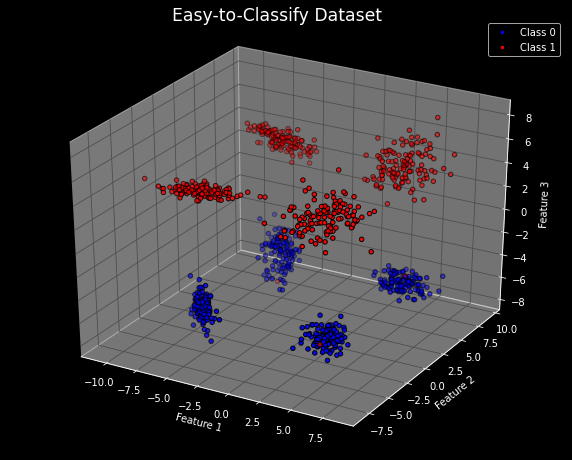

In [9]:
plot_blobs(n_clusters_per_class=4, title='Easy-to-Classify Dataset')

Напомним, что для визуализации длина ребра куба намеренно увеличена: `class_sep=5`. В датасетах, используемых далее для сравнения моделей, она будет впятеро короче: `class_sep=1` (размер кластеров при этом не меняется), поэтому кластеры будут сильно заезжать друг на друга. Это добавит датасетам сложности и естественности и не позволит моделям даже в самом легком варианте идеально разделить классы.

Посмотрим, как справятся модели с этим датасетом. Сравним качество моделей на трех его модификациях: с 3, 30 и 300 признаками, из которых значащими всегда будут только 3, т.е. доля значащих признаков будет 100, 10 и 1%.

<center>
<font color='yellow'><i>ROUND 1</i></font>

<font color='red'><b>FIGHT!</b></font>
</center>

FOREST WINS


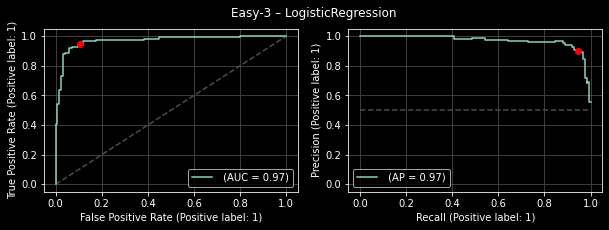

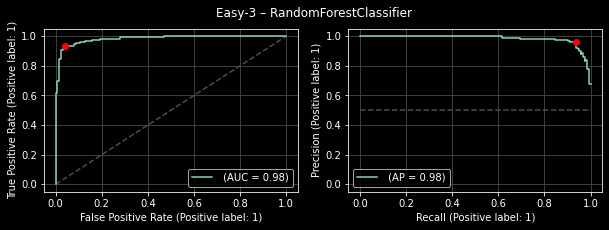

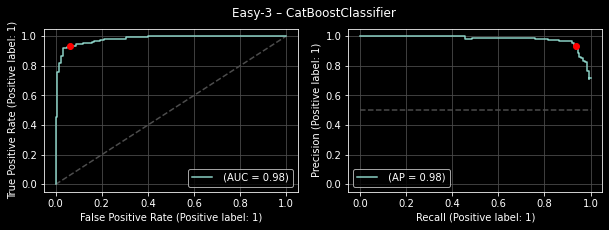

In [21]:
fight(n_clusters_per_class=4, n_features=3, cat=True,
      title='Easy-3 – ')

Датасет без незначащих признаков не вызвал затруднений ни у одной из моделей: обе метрики предельно высоки у всех. Формально лес чуть впереди логита.

LOGIT WINS


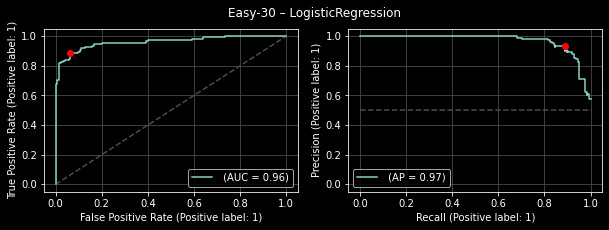

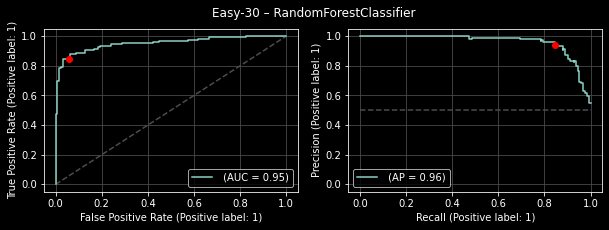

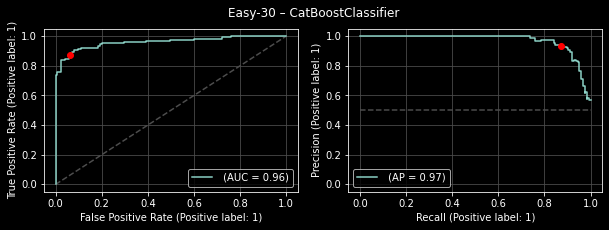

In [22]:
fight(n_clusters_per_class=4, n_features=30, cat=True,
      title='Easy-30 – ')

Снижения доли значащих признаков до 10% модели почти не заметили: метрики незначительно снизились у всех. Логит технически впереди. 

LOGIT WINS


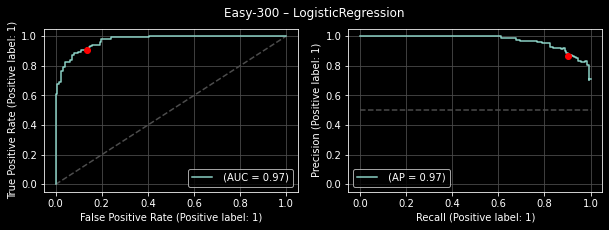

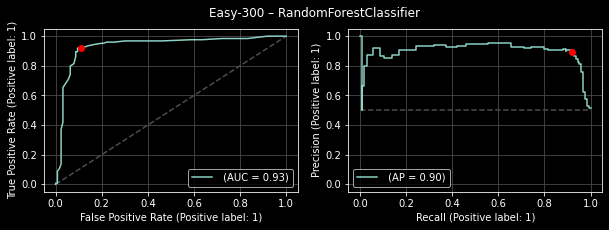

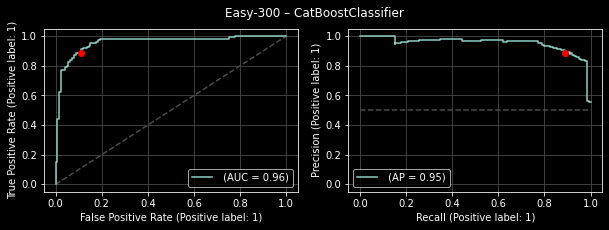

In [23]:
fight(n_clusters_per_class=4, n_features=300, cat=True,
      title='Easy-300 – ')

При 1% значащих признаков лес немного поплыл, особенно в кривой Precision-Recall. Слегка дрогнул даже CatBoost. А вот логит будто даже и не почувствовал изменений и остался лидером.

В итоге на «легком» датасете у модели логистической регрессии заметна высокая резистентность качества к увеличению доли незначащих признаков. В отличие от нее модель случайного леса демонстрирует определенную чувствительность, но к *очень большим* долям незначащих признаков. Однако *значительного* преимущества логистической регрессии по *всем* метрикам не наблюдается.

# Difficulty – Medium

Теперь сконструируем датасет средней «сложности». К каждому классу отнесем не максимальные 4, а лишь 2 кластера. Когда число кластеров на класс меньше максимального, `make_classification` распределяет их по классам если и не случайным, то по крайней мере не таким простым образом. В результате (см. диаграмму ниже) в нашем случае мы получаем пары кластеров, которые хоть и можно по-прежнему разделить плоскотью, но только плоскостью, составляющей ненулевой угол со всеми тремя осями признаков. Это значит, что для классификации важны будут *все три* признака. 

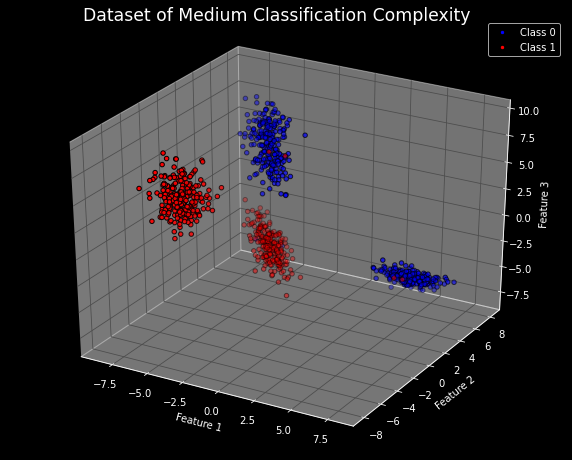

In [27]:
plot_blobs(n_clusters_per_class=2,
           title='Dataset of Medium Classification Complexity')

Снова напомним, что в «боевых» датасетах расстояние между кластерами будет гораздо меньше.

Повторим сравнение моделей на трех модификациях уже «среднего» датасета: со 100, 10 и 1% значащих признаков.

<center>
<font color='yellow'><i>ROUND 2</i></font>

<font color='red'><b>FIGHT!</b></font>
</center>

FOREST WINS


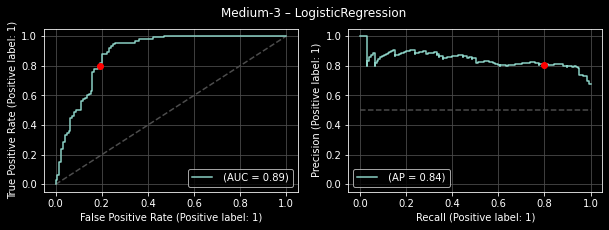

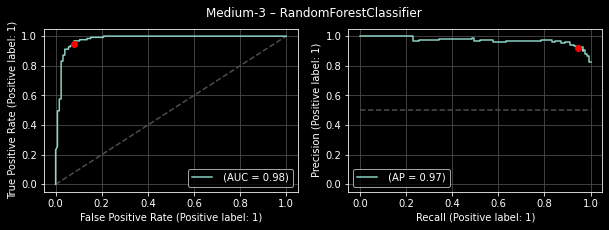

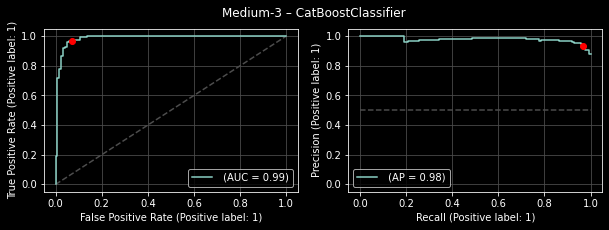

In [24]:
fight(n_clusters_per_class=2, n_features=3, cat=True,
      title='Medium-3 – ')

Логит заметно потерял в качестве уже на старте – при отсутствии незначащих признаков. А вот лес даже не заметил усложнения датасета: его метрики предельно высокие.

FOREST WINS


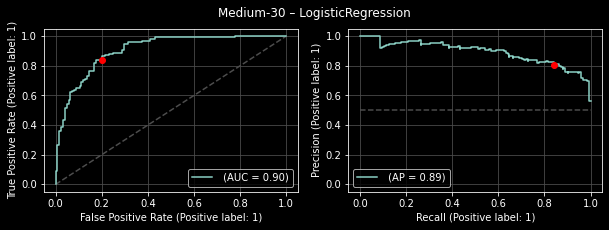

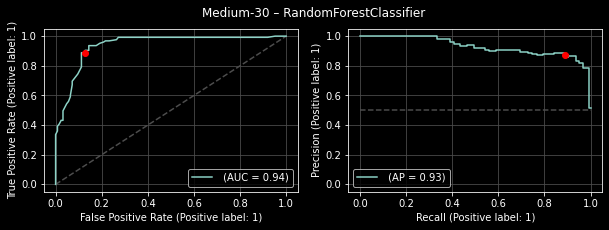

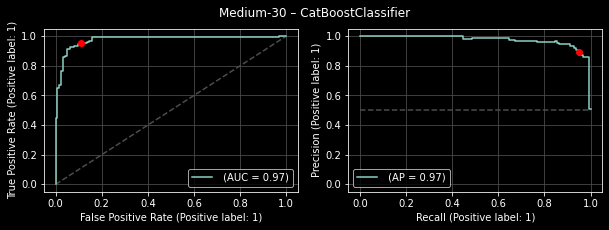

In [25]:
fight(n_clusters_per_class=2, n_features=30, cat=True,
      title='Medium-30 – ')

Снижение доли значащих признаков до 10% не сказалось на качестве логита, а лес начал немного проседать, оставаясь впереди. CatBoost пока держится.

LOGIT WINS


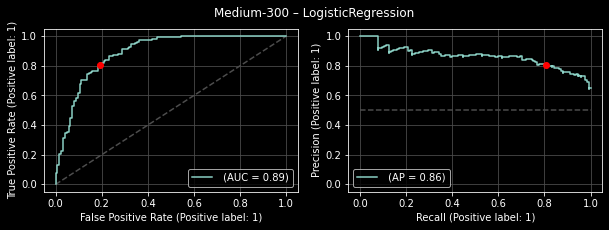

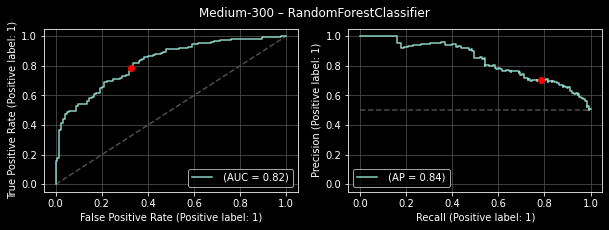

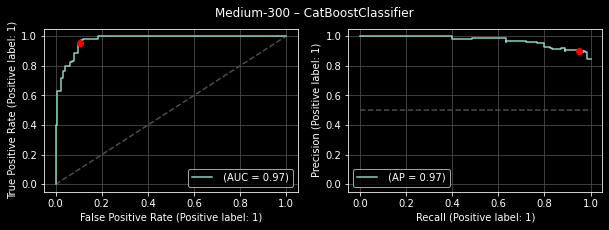

In [26]:
fight(n_clusters_per_class=2, n_features=300, cat=True,
      title='Medium-300 – ')

Вместе с падением доли значащих признаков до 1% рухнуло и качество леса: настолько, что победил логит, хоть и с не очень большим отрывом. Кэтбусту удалось удержать качество практически на исходном уровне.

В итоге на датасете средней «сложности» мы видим заметные затруднения модели логистической регрессии, но снова с нулевой чувствительностью к росту числа незначащих фич. Реакция же модели случайного леса на этот рост здесь проявилась гораздо сильнее: настолько, что она уступила регрессии при 1% значащих признаков. Но опять не приходится говорить о *значительном* преимуществе логистической регрессии по *всем* метрикам.

# Difficulty – Hard

Наконец, самый «сложный» датасет. При трех кластерах на класс можно добиться такой конфигурации кластеров (дефолтный `random state` выбран не случайно), что классы невозможно разделить не то что плоскостью, но даже какой-то понятной (по крайней мере мне :) поверхностью (см. диаграмму ниже).

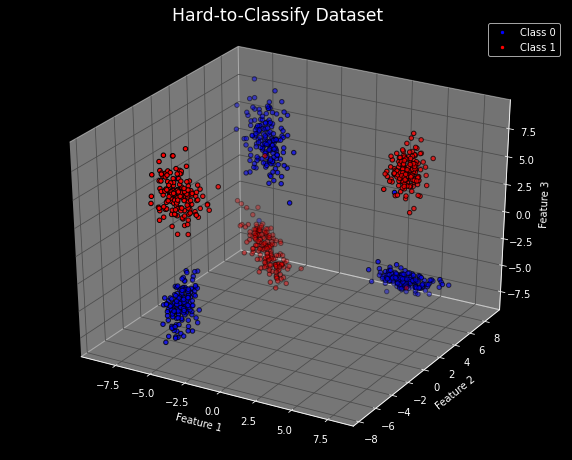

In [31]:
plot_blobs(n_clusters_per_class=3,
           title='Hard-to-Classify Dataset')

А в «боевом» варианте датасета дополнительным усложнением как всегда будет еще и пересечение кластеров из-за близости.

Как и раньше, сравним модели на трех модификациях «сложного» датасета: со 100, 10 и 1% значащих признаков. Пожелаем моделям удачи.

<center>
<font color='yellow'><i>FINAL ROUND</i></font>

<font color='red'><b>FIGHT!</b></font>
</center>

FOREST WINS


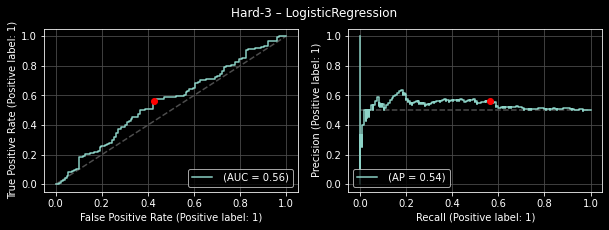

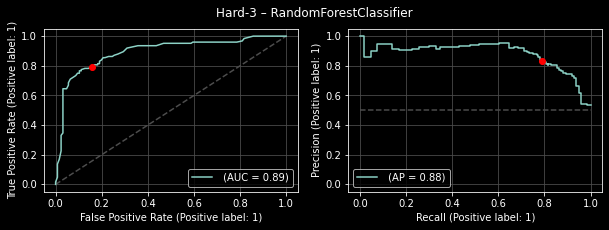

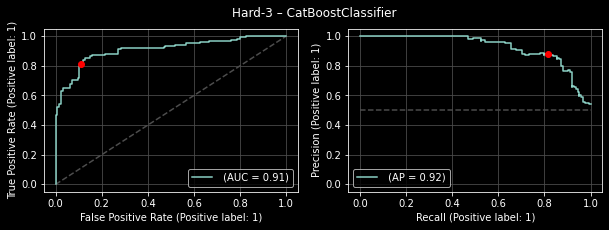

In [28]:
fight(n_clusters_per_class=3, n_features=3, cat=True,
      title='Hard-3 – ')

«Сложный» датасет оказался не по зубам логиту: его метрики качества едва ли превышают метрики случайных предсказаний. Лес на данных без незначащих признаков показывает хороший результат. CatBoost немногим лучше леса.

FOREST WINS


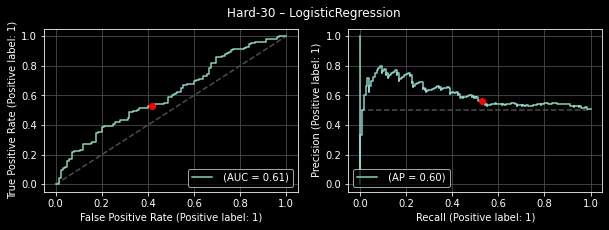

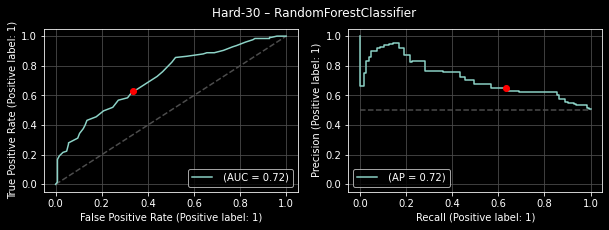

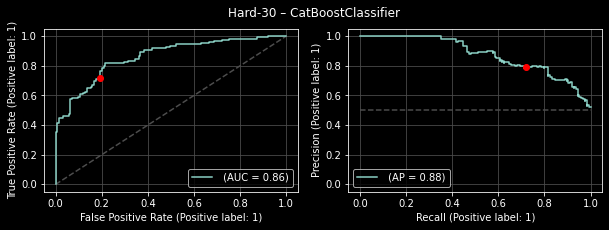

In [29]:
fight(n_clusters_per_class=3, n_features=30, cat=True,
      title='Hard-30 – ')

При снижении доли значащих признаков до 10% логит традиционно практически не меняется. Лес сильно проседает. Немного ухудшаются метрики даже у кэтбуста.

FOREST WINS


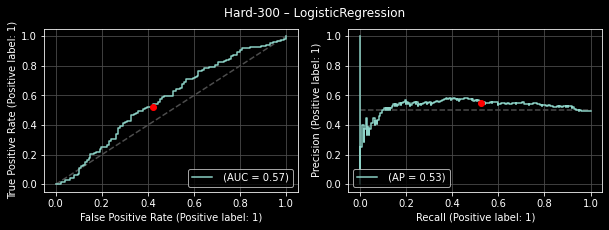

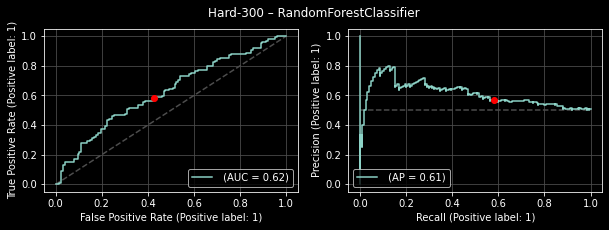

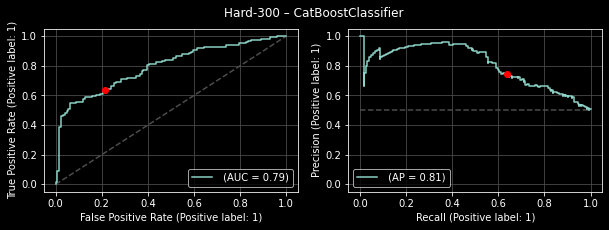

In [30]:
fight(n_clusters_per_class=3, n_features=300, cat=True,
      title='Hard-300 – ')

При доле значащих признаков в 1% качество леса окончательно проваливается и лишь немного превышает качество неизменившегося логита. Даже CatBoost проседает еще сильнее прежнего, но все же сохраняет метрики на хорошем уровне. 

«Сложный» датасет заставил попотеть даже модель CatBoost. Модель логистической регрессии же вовсе с ним не справилась: ее качество лишь немного превысило качество случайных предсказаний при любой доле значащих признаков. Зато она окончательно доказала, что нечувствительна к этой доле.

Модель случайного леса вышла победителем, однако ее чувствительность к доле незначащих признаков на «сложном» датасете проявилась сильнее всего: при увеличении доли с 0 до 99% качество упало с очень хорошего до очень плохого.



# Fatality

Сведя все результаты, получим такую таблицу, в которой красным шрифтом подсвечен победитель в каждом субраунде (CatBoost вне конкурса как бенчмарк).

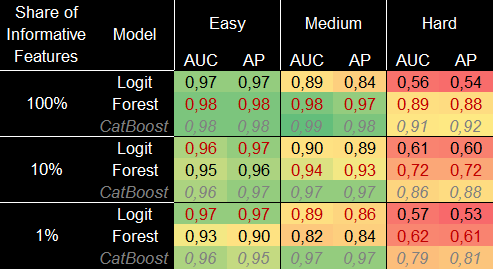

Учитывая все ограничения данного исследования, выводы будут такими.
- Исходная гипотеза подтвердилась лишь частично: при подавляющем большинстве незначащих признаков в данных модель логистической регрессии *может* показывать лучшие метрики качества, чем модель случайного леса в задаче классификации. Однако, во-первых, такое наблюдалось не всегда. Во-вторых, там, где это наблюдалось, преимущество регрессии было незначительным. 
- Качество модели логистической регрессии *нечувствительно* к наличию *сколь угодно большого* числа незначащих признаков.
- Качество модели случайного леса в задаче классификации *может* *существенно* падать при приближении доли незначащих признаков к 100%.
- Качество модели градиентного бустинга CatBoost в задаче классификации *может* *слабо* снижаться при приближении доли незначащих признаков к 100%. 

# Misc

In [ ]:
# Plots heatmap of Random Forest train scores
# on its hyperparameters search grid
# res = pd.DataFrame(forest.cv_results_)[[
#     'param_max_depth', 
#     'param_n_estimators', 
#     'mean_test_score', 
#     'rank_test_score'
# ]]
# grid = np.empty([len(MAX_DEPTH_SPACE), len(N_ESTIMATORS_SPACE)])
# grid[:] = np.nan
# for i in range(len(res)):
#     grid[res.iloc[i, 0]-1, res.iloc[i, 1]-1] = res.iloc[i, 2]
         
# plt.figure(figsize=(.2*len(N_ESTIMATORS_SPACE), .2*len(MAX_DEPTH_SPACE)));
# ax = sns.heatmap(data=grid, cbar=False,
#                  xticklabels=N_ESTIMATORS_SPACE, 
#                  yticklabels=MAX_DEPTH_SPACE);
# ax.set(xlabel='Number of Estimators', ylabel='Max Depth');

In [ ]:
# Displays Logit hyperparameters search log  
# pd.DataFrame(logit.cv_results_)[[
#     'param_penalty', 
#     'param_solver', 
#     'param_C',
#     'param_l1_ratio',
#     'mean_test_score', 
#     'rank_test_score'
# ]].sort_values('rank_test_score')